In [11]:
import matplotlib.pyplot as plt
import os
import re
from PIL import Image
import pandas as pd 
import ast
import numpy as np 
import json
import glob
import random

In [12]:
with open("proteomics_combinations.json", 'r') as file:
	protein_sets = json.load(file)

protein_categories = protein_sets['plat_response_pathways']

In [13]:
chowdry_groups = list(protein_categories.keys())

### Get slides predicted correctly for pathologist investigation

In [14]:
from sklearn.metrics import accuracy_score, roc_auc_score

def calculate_accuracy_auc_and_correct_predictions(df, threshold=0.5):
    # Predict 1 if 'p_1' is greater than the threshold, else predict 0
    df['predicted_label'] = (df['p_0'] > threshold).astype(int)

    # Create a new column for correctly predicted samples (1 for correct, 0 for incorrect)
    df['correct_prediction'] = (df['predicted_label'] == df['label']).astype(int)

    # Calculate accuracy
    accuracy = accuracy_score(df['label'], df['predicted_label'])

    # Calculate AUC-ROC
    auc_roc = roc_auc_score(df['label'], df['p_0'])

    return accuracy, auc_roc, df


# switched labels... 

results = pd.read_csv("/mnt/ncshare/ozkilim/BRCA/heatmaps/results/HGSOC_clm_sb.csv")
# results = results[0:300]
# Calculate accuracy, AUC-ROC and get DataFrame with correct predictions
accuracy, auc_roc, df_with_correct_predictions = calculate_accuracy_auc_and_correct_predictions(results, threshold=0.5)
print("Accuracy:", accuracy)
print("AUC-ROC:", auc_roc)

df_with_correct_predictions[["correct_prediction","slide_id"]]

# 1. why reversed?....
# 2. 

Accuracy: 0.7241379310344828
AUC-ROC: 0.5479497354497356


,correct_prediction,slide_id
0,1,1009466_171125_ImageActual
1,1,1009467_416633_ImageActual
2,0,1009790_271240_ImageActual
3,0,1009793_271271_ImageActual
4,1,1009481_416637_ImageActual
...,...,...
169,1,1009620_269129_ImageActual
170,1,1009666_269175_ImageActual
171,1,1009667_269176_ImageActual
172,1,1009646_269155_ImageActual


In [15]:
def get_single_png_file(folder_path):
    # Check if the folder path ends with 'mask'
    # List all files in the directory
    files = os.listdir(folder_path)

    # Find the first PNG file
    for file in files:
        if file.endswith("mask.jpg"):
            return os.path.join(folder_path, file)

    print("No PNG file found in the directory.")
    return None


def get_clam_sb_heatmap(folder_path):
    # Check if the folder path ends with 'mask'
    # List all files in the directory
    files = os.listdir(folder_path)

    # Find the first PNG file
    for file in files:
        if file.endswith("_0.png"):
            return os.path.join(folder_path, file)

    print("No clam_sb_heatmap file found in the directory.")
    return None

def find_first_npy_file(folder_path):
    # Create a search pattern for .npy files
    search_pattern = os.path.join(folder_path, '*.npy')

    # List all .npy files in the folder
    npy_files = glob.glob(search_pattern)

    # Return the first .npy file found, or None if there are no such files
    return npy_files[0] if npy_files else None


def format_row_for_title(row):
    # Select the columns you want to include in the title
    columns_of_interest = ["Tumor response", "Tumor type", "Tumor location", "Tumor Grade", "Tumor Stage"]

    # Create a formatted string with bold values
    title_parts = [f"{col}: $\mathbf{{{row[col]}}}$" for col in columns_of_interest if pd.notna(row[col])]
    formatted_title = ", ".join(title_parts)


    return formatted_title



def load_random_png_images(folder_path, num_images=10):
    # List all PNG files in the folder
    all_png_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    
    # Randomly sample num_images files
    sampled_files = random.sample(all_png_files, min(num_images, len(all_png_files)))

    # Load images and convert to numpy arrays
    image_arrays = []
    for file in sampled_files:
        img = Image.open(os.path.join(folder_path, file))
        img_array = np.array(img)
        image_arrays.append(img_array)

    return image_arrays


def get_cross_attns(folder_path):
    # Regex pattern to match filenames ending with a number and '.png'
    pattern = re.compile(r'\d\.png$')

    # List to hold the paths of matching files
    matching_files = []

    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is a PNG and ends with a number
        if pattern.search(filename):
            # Add the full path to the list
            full_path = os.path.join(folder_path, filename)
            matching_files.append(full_path)

    return matching_files


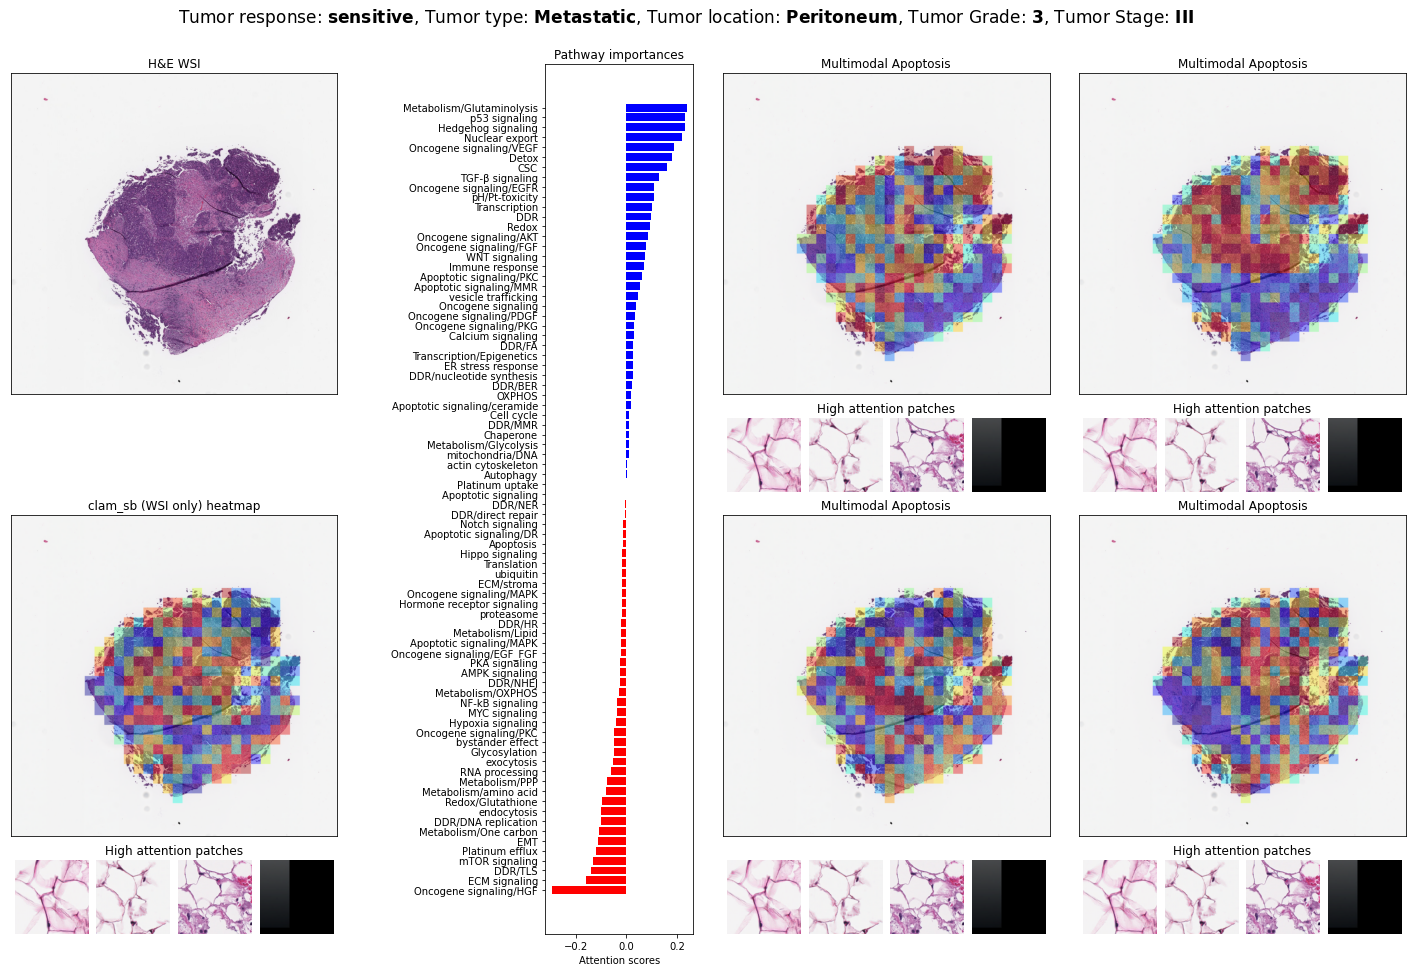

In [30]:
# Make plit with layout of image and then heatmaps with patches.. get patches part to work...? 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


image = "1009512_171142_ImageActual"
metadata = pd.read_excel("/mnt/ncshare/ozkilim/BRCA/data/HGSOC_processed_data/PTRC-HGSOC_List_clincal_data.xlsx")
metadata = metadata.loc[metadata['File Name']==image]
row_to_format = metadata.iloc[0]
# Format the row for title
formatted_title = format_row_for_title(row_to_format)
# get matedata and decide what taches to show 


pathes_0 = '/mnt/ncshare/ozkilim/BRCA/heatmaps/HGSOC_heatmaps/heatmap_production_results/HGSOC_clm_sb_UAB/sampled_patches/label_Unspecified_pred_1/topk_high_attention'
pathes_1 = '/mnt/ncshare/ozkilim/BRCA/heatmaps/HGSOC_heatmaps/heatmap_production_results/HGSOC_clm_sb_UAB/sampled_patches/label_Unspecified_pred_1/topk_high_attention'


# Set the path to the folder containing the images
folder_path = '/mnt/ncshare/ozkilim/BRCA/heatmaps/HGSOC_heatmaps/heatmap_raw_results/HGSOC_MCAT_mayo/Unspecified/' + image
regex = re.compile(r'(\d+)\.png$')
# List and sort the PNG files in the folder based on the number at the end of the filename
image_files = [f for f in os.listdir(folder_path) if regex.search(f)]
image_files.sort(key=lambda f: int(regex.search(f).group(1)))

# Create a figure
fig = plt.figure(figsize=(25, 16))
# Define the grid layout
gs = gridspec.GridSpec(10, 8, figure=fig)  # Example: 3 rows, 6 columns

# Create subplots
ax1 = fig.add_subplot(gs[0:4, :2]) 
ax2 = fig.add_subplot(gs[5:9, :2]) 
ax2_patches = fig.add_subplot(gs[9:, :2])

ax3 = fig.add_subplot(gs[0:, 3:4]) 


ax5 = fig.add_subplot(gs[0:4, 4:6])
ax5_patches = fig.add_subplot(gs[4:5, 4:6])

ax6 = fig.add_subplot(gs[0:4, 6:])
ax6_patches = fig.add_subplot(gs[4:5, 6:])

ax7 = fig.add_subplot(gs[5:9, 4:6])
ax7_patches = fig.add_subplot(gs[9:, 4:6])

ax8 = fig.add_subplot(gs[5:9, 6:])
ax8_patches = fig.add_subplot(gs[9:, 6:])


# Show HandE
H_and_E = get_single_png_file(folder_path)
H_and_E = Image.open(H_and_E)
ax1.imshow(H_and_E)

# Show clam_sb heatmap baseline
clam_sb_folder_path = '/mnt/ncshare/ozkilim/BRCA/heatmaps/HGSOC_heatmaps/heatmap_raw_results/HGSOC_clm_sb_UAB/Unspecified/' + image
clam_heatmap = get_clam_sb_heatmap(clam_sb_folder_path)
clam_heatmap = Image.open(clam_heatmap)


ax2.imshow(clam_heatmap)


# # Show pathways attentions.
npy_file_path = find_first_npy_file(folder_path)
npy_file_path = "/mnt/ncshare/ozkilim/BRCA/heatmaps/HGSOC_heatmaps/heatmap_raw_results/HGSOC_MCAT_Mayo_plat_resp_clusters/Unspecified/1009481_416637_ImageActual/omics_attns.npy"
omics_attns = np.load(npy_file_path)
values = omics_attns.copy()[0]
sorted_indices = np.argsort(values)
sorted_strings = np.array(chowdry_groups)[sorted_indices]
sorted_values = values[sorted_indices]
sorted_values = sorted_values-0.4
# Plotting each bar individually to assign colors
for i in range(len(sorted_values)):
    color = 'blue' if sorted_values[i] > 0 else 'red'
    ax3.barh(sorted_strings[i], sorted_values[i], color=color)
# Set labels and title if necessary
ax3.set_xlabel('Attention scores')
ax3.set_title('Pathway importances')



# TODO mechanism to chose only most important heatmaps automated ... 


# plot patches  from heatmap of importance
clam_sb_patch_arrays = load_random_png_images(pathes_0)
inner_gs = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=ax2_patches,wspace=0, hspace=0)
# Iterate through the inner grid and plot images
for j in range(4):
    ax = fig.add_subplot(inner_gs[0, j])
    ax.imshow(clam_sb_patch_arrays[j])
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])


# Plot co-attention heatmaps.

# one by one... 
mutlimodal_heatmap_paths = get_cross_attns(folder_path)
clam_heatmap = Image.open(mutlimodal_heatmap_paths[0])
ax5.imshow(clam_heatmap)


pathway = "Apoptosis"
ax5.set_title("Multimodal " + pathway)

inner_gs = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=ax5_patches,wspace=0, hspace=0)
# Iterate through the inner grid and plot images
for j in range(4):
    ax = fig.add_subplot(inner_gs[0, j])
    ax.imshow(clam_sb_patch_arrays[j])
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])


clam_heatmap = Image.open(mutlimodal_heatmap_paths[1])
ax6.imshow(clam_heatmap)
pathway = "Apoptosis"
ax6.set_title("Multimodal " + pathway)

inner_gs = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=ax6_patches,wspace=0, hspace=0)
# Iterate through the inner grid and plot images
for j in range(4):
    ax = fig.add_subplot(inner_gs[0, j])
    ax.imshow(clam_sb_patch_arrays[j])
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])


clam_heatmap = Image.open(mutlimodal_heatmap_paths[2])
ax7.imshow(clam_heatmap)
pathway = "Apoptosis"
ax7.set_title("Multimodal " + pathway)

inner_gs = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=ax7_patches,wspace=0, hspace=0)
# Iterate through the inner grid and plot images
for j in range(4):
    ax = fig.add_subplot(inner_gs[0, j])
    ax.imshow(clam_sb_patch_arrays[j])
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])


clam_heatmap = Image.open(mutlimodal_heatmap_paths[3])
ax8.imshow(clam_heatmap)
pathway = "Apoptosis"
ax8.set_title("Multimodal " + pathway)

inner_gs = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=ax8_patches,wspace=0, hspace=0)
# Iterate through the inner grid and plot images
for j in range(4):
    ax = fig.add_subplot(inner_gs[0, j])
    ax.imshow(clam_sb_patch_arrays[j])
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])

# plotting all heatmaps/ highest ranked

# Loop over the grid and add the images
# for i, ax in enumerate(axes.flatten()):
#     if i < len(image_files):
#         img_path = os.path.join(folder_path, image_files[i])
#         img = Image.open(img_path)
#         ax.imshow(img)
#         pathway_title = chowdry_groups[i]
#         ax.set_title(pathway_title,fontsize=12)
#         ax.axis('off')
#     else:
#         ax.axis('off')

# Adjust layout

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("H&E WSI")


ax2.set_xticks([])
ax2.set_yticks([])
ax2_patches.axis('off') 
ax2.set_title("clam_sb (WSI only) heatmap")
ax2_patches.set_title("High attention patches")


ax5.set_xticks([])
ax5.set_yticks([])
ax5_patches.set_xticks([])
ax5_patches.set_yticks([])
ax5_patches.axis('off') 
ax5_patches.set_title("High attention patches")



ax6.set_xticks([])
ax6.set_yticks([])
ax6_patches.set_xticks([])
ax6_patches.set_yticks([])
ax6_patches.axis('off') 
ax6_patches.set_title("High attention patches")

ax7.set_xticks([])
ax7.set_yticks([])
ax7_patches.set_xticks([])
ax7_patches.set_yticks([])
ax7_patches.axis('off') 
ax6_patches.set_title("High attention patches")

ax8.set_xticks([])
ax8.set_yticks([])
ax8_patches.set_xticks([])
ax8_patches.set_yticks([])
ax8_patches.axis('off') 
ax8_patches.set_title("High attention patches")


plt.suptitle(formatted_title, y=0.93, fontsize=17)


# add patches! re-design subplots dims... 

# display metadata on the plot 

# # Display the plot
# fig.patch.set_facecolor('white')  # Set the background color of the figure to white
# # Saving the figure in high quality
# output_file = 'HGSOC_MCAT_histo_proteo_cross_attn.png'  # Specify your output path and file name
output_filepath = "/mnt/ncshare/ozkilim/BRCA/figures/intepretability" + image + ".png"
plt.savefig(output_filepath, bbox_inches='tight', dpi=300, facecolor=fig.get_facecolor())  # Save with high resolution

plt.show()

In [ ]:
# analysis of pathways most important in refractory and ...